In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [33]:
# Bina yapılarını içeren csv dosyası
b = pd.read_csv("/content/sample_data/csv_building_structure.csv")

# İlçe isimlerini içeren csv dosyası
df = pd.read_csv("/content/sample_data/ward_vdcmun_district_name_mapping.csv")



df=df[['district_id','district_name']]

# district_id'si ve district_name'i aynı olan satırları silme
df = df.drop_duplicates(subset=['district_id', 'district_name'], keep='first')

# damage_grade'i boş olan satırları silme
b = b.dropna(subset=['damage_grade'])

# Bina yapım yılı kolonu eklenmesi
today = datetime.date.today()

year = today.year

b['building_creation_year'] = 2015 - b['age_building']

# Floatları integer'a çevirme
for column in b.columns:
  if b[column].dtype == 'float64':
    b[column] = b[column].fillna(0).astype(int)

# Hasar seviyesini Stringden integer'a çevirme
def extract_grade_number(grade):
  if pd.isnull(grade):
    return np.nan
  else:
    return int(grade.split()[-1])

b['damage_grade'] = b['damage_grade'].apply(extract_grade_number)

In [34]:
b

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed,building_creation_year
0,120101000011,12,1207,120703,1,1,9,288,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,1,0,0,0,Damaged-Used in risk,3,Major repair,2006
1,120101000021,12,1207,120703,1,1,15,364,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,1,0,0,0,Damaged-Repaired and used,5,Reconstruction,2000
2,120101000031,12,1207,120703,1,1,20,384,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,2,Minor repair,1995
3,120101000041,12,1207,120703,1,1,20,312,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,2,Minor repair,1995
4,120101000051,12,1207,120703,1,1,30,308,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,1,Minor repair,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762101,366709001241,36,3603,360302,2,0,60,165,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-2 side,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,5,Reconstruction,1955
762102,366709001251,36,3603,360302,2,0,35,342,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-1 side,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,5,Reconstruction,1980
762103,366709001261,36,3603,360302,2,0,35,342,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,5,Reconstruction,1980
762104,366709001271,36,3603,360302,2,0,19,306,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,5,Reconstruction,1996


In [35]:
# Tutarsız verileri silme

b = b.drop(b[(b['damage_grade'] == 5) & ((b['height_ft_pre_eq'] == b['height_ft_post_eq']) | (b['count_floors_pre_eq'] == b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] == 4) & ((b['height_ft_pre_eq'] == b['height_ft_post_eq']) | (b['count_floors_pre_eq'] == b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] == 1) & ((b['height_ft_pre_eq'] != b['height_ft_post_eq']) & (b['count_floors_pre_eq'] != b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] == 3) & ((b['height_ft_pre_eq'] == 0) | (b['count_floors_pre_eq'] == 0))].index)
b = b.drop(b[(b['damage_grade'] != 5) & ((b['height_ft_pre_eq'] == 0) | (b['count_floors_pre_eq'] == 0))].index)
b = b[b['building_creation_year'] <= 2010]

# Teknik çözüme göre tutarsız verileri silme

b = b.drop(b[(b['damage_grade'] == 1) & ((b['height_ft_pre_eq'] > b['height_ft_post_eq']) | (b['count_floors_pre_eq'] > b['count_floors_post_eq']))].index)
b = b.drop(b[(b['damage_grade'] <= 2) & (b['technical_solution_proposed'] == 'Reconstruction')].index)
b = b.drop(b[(b['damage_grade'] <= 2) & (b['technical_solution_proposed'] == 'Major repair')].index)
b = b.drop(b[(b['damage_grade'] == 5) & (b['technical_solution_proposed'] != 'Reconstruction')].index)
b = b.drop(b[(b['damage_grade'] == 4) & (b['technical_solution_proposed'] == 'Minor repair')].index)
b = b.drop(b[(b['age_building'] > 50) & (b['damage_grade'] == 2)].index)
b = b.drop(b[(b['condition_post_eq'] == 'Damaged-Used in risk') & (b['damage_grade'] == 5)].index)

In [36]:
# b ve df verisetleri district_id'ye göre birleştirildi

merged_df = pd.merge(b, df[['district_id', 'district_name']], on='district_id', how='left')

# İlçelere göre hissedilen deprem büyüklükleri ve bu büyüklükleri birbirlerine göre katları eklendi

merged_df.loc[merged_df['district_name'] == 'Okhaldhunga', 'magnitude_felt'] = 1
merged_df.loc[merged_df['district_name'] == 'Okhaldhunga', 'magnitude'] = 5.5
merged_df.loc[merged_df['district_name'] == 'Sindhuli', 'magnitude_felt'] = 5
merged_df.loc[merged_df['district_name'] == 'Sindhuli', 'magnitude'] = 6.25
merged_df.loc[merged_df['district_name'] == 'Ramechhap', 'magnitude_felt'] = 20
merged_df.loc[merged_df['district_name'] == 'Ramechhap', 'magnitude'] = 6.75
merged_df.loc[merged_df['district_name'] == 'Dolakha', 'magnitude_felt'] = 80
merged_df.loc[merged_df['district_name'] == 'Dolakha', 'magnitude'] = 7.3
merged_df.loc[merged_df['district_name'] == 'Sindhupalchok', 'magnitude_felt'] = 40
merged_df.loc[merged_df['district_name'] == 'Sindhupalchok', 'magnitude'] = 7.0
merged_df.loc[merged_df['district_name'] == 'Kavrepalanchok', 'magnitude_felt'] = 18
merged_df.loc[merged_df['district_name'] == 'Kavrepalanchok', 'magnitude'] = 6.75
merged_df.loc[merged_df['district_name'] == 'Nuwakot', 'magnitude_felt'] = 30
merged_df.loc[merged_df['district_name'] == 'Nuwakot', 'magnitude'] = 6.9
merged_df.loc[merged_df['district_name'] == 'Rasuwa', 'magnitude_felt'] = 20
merged_df.loc[merged_df['district_name'] == 'Rasuwa', 'magnitude'] = 6.75
merged_df.loc[merged_df['district_name'] == 'Dhading', 'magnitude_felt'] = 40
merged_df.loc[merged_df['district_name'] == 'Dhading', 'magnitude'] = 7.0
merged_df.loc[merged_df['district_name'] == 'Makwanpur', 'magnitude_felt'] = 11
merged_df.loc[merged_df['district_name'] == 'Makwanpur', 'magnitude'] = 6.5
merged_df.loc[merged_df['district_name'] == 'Gorkha', 'magnitude_felt'] = 250
merged_df.loc[merged_df['district_name'] == 'Gorkha', 'magnitude'] = 7.8

b=merged_df

In [37]:
# Tutarsız veriler siliniyor
result_df_1 = b[(b['age_building'] > 70) & (b['count_floors_pre_eq'] >= 3) & (b['height_ft_post_eq'] != 0) & (b['damage_grade'] == 3)]
b = b.drop(result_df_1.index)
result_df_2 = b[(b['age_building'] > 100) & (b['count_floors_pre_eq'] >= 2) & (b['height_ft_post_eq'] != 0) & (b['damage_grade'] == 3)]
b = b.drop(result_df_2.index)
result_df_3 = b[(b['age_building'] > 70) & (b['magnitude'] >= 6) & (b['damage_grade'] == 1)]
b = b.drop(result_df_3.index)
result_df_4 = b[(b['age_building'] > 130)]
b = b.drop(result_df_4.index)
result_df_5 = b[(b['plinth_area_sq_ft'] > 700)]
b = b.drop(result_df_5.index)
result_df_6 = b[(b['height_ft_pre_eq'] >= 40)]
b = b.drop(result_df_6.index)

# Hasar seviyesi 2 ve 3 olanlar artık 2
# 4 ve 5 olanlar da 3 olacak
b.loc[b['damage_grade'].isin([2, 3]), 'damage_grade'] = 2
b.loc[b['damage_grade'].isin([4, 5]), 'damage_grade'] = 3

# Boş satırlar siliniyor
b = b.dropna()

In [38]:
# Deprem öncesi kat sayısında tutarsız verilerin silinmesi

b = b[~((b['damage_grade'] == 1) & (b['count_floors_pre_eq'] != b['count_floors_pre_eq']))]
b = b[~((b['damage_grade'] == 2) & (b['count_floors_pre_eq'] == b['count_floors_post_eq']))]
b = b[~((b['damage_grade'] == 3) & (b['count_floors_post_eq'] != 0))]

b = b[~((b['damage_grade'] == 1) & (b['height_ft_pre_eq'] != b['height_ft_pre_eq']))]
b = b[~((b['damage_grade'] == 2) & (b['height_ft_pre_eq'] == b['height_ft_post_eq']))]
b = b[~((b['damage_grade'] == 3) & (b['height_ft_post_eq'] != 0))]

# Major repair ve Minor repair'ler Repair olacak

b['technical_solution_proposed'] = b['technical_solution_proposed'].replace(['Major repair', 'Minor repair'], 'Repair')

# technical_solution_proposed kolonundaki tutarsız satırlar siliniyor

b = b[~((b['damage_grade'] == 2) & (b['technical_solution_proposed'] == 'No Need'))]
b = b[~((b['damage_grade'] == 2) & (b['technical_solution_proposed'] == 'Reconstruction'))]
b = b[~((b['damage_grade'] == 1) & (b['technical_solution_proposed'] == 'Reconstruction'))]
b = b[~((b['damage_grade'] == 3) & (b['technical_solution_proposed'] != 'Reconstruction'))]

In [39]:
pd.set_option('display.max_columns', 500)
b

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed,building_creation_year,district_name,magnitude_felt,magnitude
3,120101000051,12,1207,120703,1,1,30,308,9,9,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,1,Repair,1985,Okhaldhunga,1.0,5.5
5,120101000071,12,1207,120703,1,0,13,234,9,0,Flat,Other,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble unclear,3,Reconstruction,2002,Okhaldhunga,1.0,5.5
9,120101000121,12,1207,120703,2,2,15,528,21,21,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Not damaged,1,Repair,2000,Okhaldhunga,1.0,5.5
10,120101000131,12,1207,120703,2,2,18,528,21,21,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,1,No need,1997,Okhaldhunga,1.0,5.5
12,120101000161,12,1207,120703,2,2,7,330,19,19,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Repaired and used,1,No need,2008,Okhaldhunga,1.0,5.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513802,366709001231,36,3603,360302,2,2,13,513,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-1 side,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Not damaged,1,Repair,2002,Gorkha,250.0,7.8
513803,366709001241,36,3603,360302,2,0,60,165,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-2 side,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,3,Reconstruction,1955,Gorkha,250.0,7.8
513804,366709001251,36,3603,360302,2,0,35,342,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Attached-1 side,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,3,Reconstruction,1980,Gorkha,250.0,7.8
513805,366709001261,36,3603,360302,2,0,35,342,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,Timber-Planck,Not attached,Rectangular,0,1,0,0,0,0,0,0,0,0,0,Damaged-Rubble clear,3,Reconstruction,1980,Gorkha,250.0,7.8


<ipython-input-12-7f33d8d2e21e>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-12-7f33d8d2e21e>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-12-7f33d8d2e21e>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

XGBoost Accuracy: 0.932
Random Forest Accuracy: 0.93


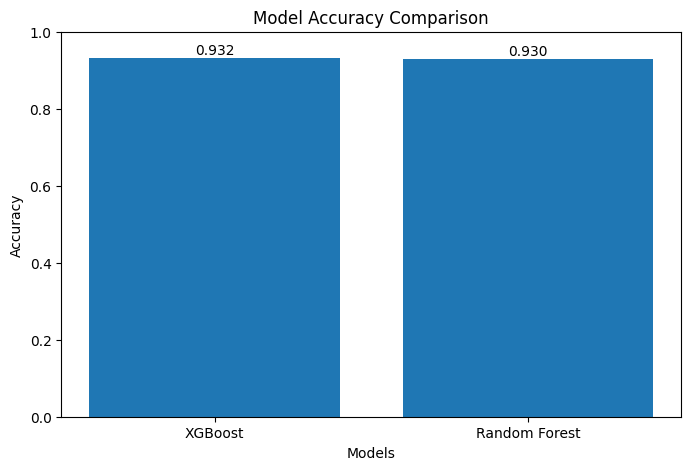

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn import linear_model



data = b


features = [
    "plinth_area_sq_ft",
    "magnitude_felt",
    "magnitude",
    "land_surface_condition",
    "count_floors_pre_eq",
    "height_ft_pre_eq",
    "roof_type",
    "age_building",
    "foundation_type",
    "ground_floor_type",
    "other_floor_type",
    "has_superstructure_adobe_mud",
    "has_superstructure_stone_flag",
    "has_superstructure_cement_mortar_stone",
    "has_superstructure_mud_mortar_brick",
    "has_superstructure_cement_mortar_brick",
    "has_superstructure_timber",
    "has_superstructure_bamboo",
    "has_superstructure_rc_non_engineered",
    "has_superstructure_rc_engineered",
    "has_superstructure_other",
]

target = "damage_grade"

X = data[features]
y = data[target] - 1

# Convert categorical features to numerical using Label Encoding
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dictionary to store feature weights
feature_weights = {
    "magnitude_felt": 5,
    "magnitude": 5,
    "roof_type": 2,
    "age_building":5,
    "ground_floor_type": 2,
    "other_floor_type": 2,
    "foundation_type":4,
    "has_superstructure_cement_mortar_stone":2,
    "has_superstructure_mud_mortar_brick":2,
    "has_superstructure_cement_mortar_brick":2,
}

# Assign weights to features in X_train and X_test
for feature, weight in feature_weights.items():
    if feature in X_train.columns:
        X_train[feature] = X_train[feature] * weight
    if feature in X_test.columns:
        X_test[feature] = X_test[feature] * weight


# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print("XGBoost Accuracy:", round(xgb_accuracy, 3))

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest Accuracy:", round(rf_accuracy, 3))

import matplotlib.pyplot as plt

# Doğruluk değerlerini listeye ekle
model_names = ['XGBoost', 'Random Forest']
accuracies = [xgb_accuracy, rf_accuracy]

# Grafik oluştur
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)  # Doğruluk oranları 0-1 arasında olduğundan eksen sınırlarını ayarlayın
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(model_names)
plt.bar_label(plt.bar(model_names, accuracies), fmt='%.3f')  # Doğrulukları sütun üzerinde göster
plt.show()

<ipython-input-45-06a0c26f7d46>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-45-06a0c26f7d46>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = le.fit_transform(X[column])
<ipython-input-45-06a0c26f7d46>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

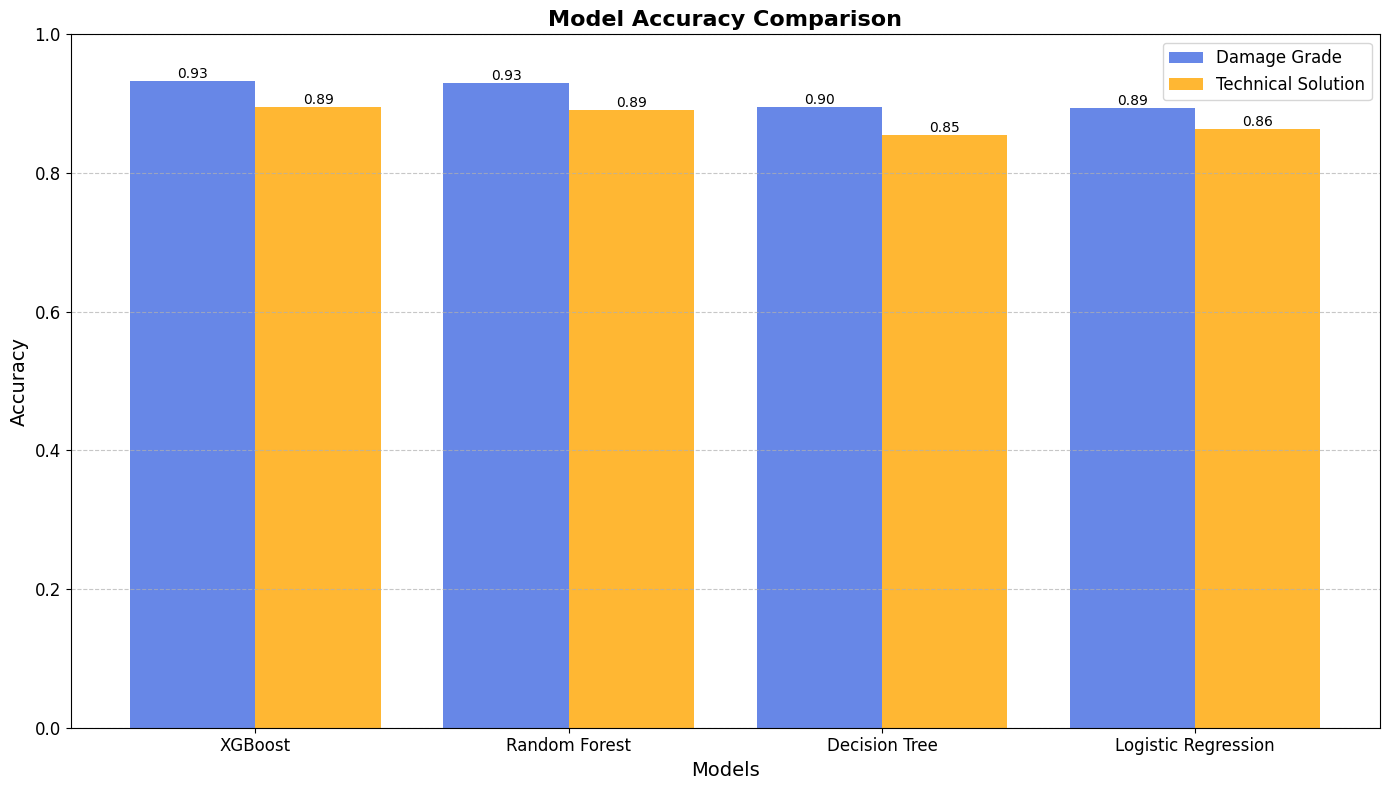

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

# Özellikler ve hedefler
features = [
    "plinth_area_sq_ft", "magnitude_felt", "magnitude",
    "land_surface_condition", "count_floors_pre_eq", "height_ft_pre_eq",
    "roof_type", "age_building", "foundation_type",
    "ground_floor_type", "other_floor_type", "has_superstructure_adobe_mud", "has_superstructure_stone_flag",
    "has_superstructure_cement_mortar_stone", "has_superstructure_mud_mortar_brick", "has_superstructure_cement_mortar_brick", "has_superstructure_timber",
    "has_superstructure_bamboo", "has_superstructure_rc_non_engineered", "has_superstructure_rc_engineered", "has_superstructure_other",
]

data = b

target_damage = "damage_grade"
target_solution = "technical_solution_proposed"

X = data[features]
y_damage = data[target_damage] - 1
y_solution = data[target_solution]

# Kategorik verilerin encode edilmesi
for column in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
le_solution = LabelEncoder()
y_solution = le_solution.fit_transform(y_solution)

# Eğitim ve test setlerinin oluşturulması
X_train, X_test, y_damage_train, y_damage_test, y_solution_train, y_solution_test = train_test_split(
    X, y_damage, y_solution, test_size=0.2, random_state=42
)

# Kolon önem ağırlıkları
feature_weights = {
    "magnitude_felt": 5, "magnitude": 5, "roof_type": 2, "age_building": 5,
    "ground_floor_type": 2, "other_floor_type": 2, "foundation_type": 4,
    "has_superstructure_cement_mortar_stone": 2,
    "has_superstructure_mud_mortar_brick": 2,
    "has_superstructure_cement_mortar_brick": 2
}

for feature, weight in feature_weights.items():
    if feature in X_train.columns:
        X_train[feature] = X_train[feature] * weight
    if feature in X_test.columns:
        X_test[feature] = X_test[feature] * weight

# Modellerin tanımlanması
models = {
    "XGBoost": XGBClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000)
}

accuracies_damage = {}
accuracies_solution = {}

# Modellerin eğitilmesi ve doğruluk hesaplamaları
for model_name, model in models.items():
    model.fit(X_train, y_damage_train)
    y_damage_pred = model.predict(X_test)
    accuracies_damage[model_name] = accuracy_score(y_damage_test, y_damage_pred)

    model.fit(X_train, y_solution_train)
    y_solution_pred = model.predict(X_test)
    accuracies_solution[model_name] = accuracy_score(y_solution_test, y_solution_pred)

# Grafik için verilerin hazırlanması
model_names = list(models.keys())
damage_accuracies = list(accuracies_damage.values())
solution_accuracies = list(accuracies_solution.values())

X_axis = np.arange(len(model_names))
plt.figure(figsize=(14, 8))
bar_width = 0.4

# Bar grafiği çizimi
bars1 = plt.bar(X_axis - bar_width / 2, damage_accuracies, bar_width, label='Damage Grade', color='royalblue', alpha=0.8)
bars2 = plt.bar(X_axis + bar_width / 2, solution_accuracies, bar_width, label='Technical Solution', color='orange', alpha=0.8)

# Barların üzerine değerlerin eklenmesi
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.2f}", ha='center', va='bottom', fontsize=10)

for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f"{height:.2f}", ha='center', va='bottom', fontsize=10)

# Grafik özelleştirmeleri
plt.xticks(X_axis, model_names, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Models", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Model Accuracy Comparison", fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


In [54]:
b['technical_solution_proposed'].unique()

array(['Repair', 'Reconstruction', 'No need'], dtype=object)

In [64]:
sample_row = b.iloc[14035]

temp = sample_row[['plinth_area_sq_ft', 'magnitude_felt', 'magnitude',
                   'land_surface_condition', 'count_floors_pre_eq', 'height_ft_pre_eq',
                   'roof_type', 'age_building', 'foundation_type', 'ground_floor_type', 'other_floor_type',
                   'has_superstructure_adobe_mud', 'has_superstructure_stone_flag', 'has_superstructure_cement_mortar_stone',
                   'has_superstructure_mud_mortar_brick', 'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
                   'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered', 'has_superstructure_rc_engineered',
                   'has_superstructure_other']]

manuel_degerler = {
    "plinth_area_sq_ft": sample_row['plinth_area_sq_ft'],
    "magnitude_felt": sample_row['magnitude_felt'],
    "magnitude": sample_row['magnitude'],
    "land_surface_condition": sample_row['land_surface_condition'],
    "count_floors_pre_eq": sample_row['count_floors_pre_eq'],
    "height_ft_pre_eq": sample_row['height_ft_pre_eq'],
    "roof_type": sample_row["roof_type"],
    "age_building": sample_row['age_building'],
    "foundation_type": sample_row["foundation_type"],
    "ground_floor_type": sample_row["ground_floor_type"],
    "other_floor_type": sample_row["other_floor_type"],
    "has_superstructure_adobe_mud": sample_row["has_superstructure_adobe_mud"],
    "has_superstructure_stone_flag": sample_row["has_superstructure_stone_flag"],
    "has_superstructure_cement_mortar_stone": sample_row["has_superstructure_cement_mortar_stone"],
    "has_superstructure_mud_mortar_brick": sample_row["has_superstructure_mud_mortar_brick"],
    "has_superstructure_cement_mortar_brick": sample_row["has_superstructure_cement_mortar_brick"],
    "has_superstructure_timber": sample_row["has_superstructure_timber"],
    "has_superstructure_bamboo": sample_row["has_superstructure_bamboo"],
    "has_superstructure_rc_non_engineered": sample_row["has_superstructure_rc_non_engineered"],
    "has_superstructure_rc_engineered": sample_row["has_superstructure_rc_engineered"],
    "has_superstructure_other": sample_row["has_superstructure_other"]
}

manuel_df = pd.DataFrame([manuel_degerler])

manuel_df = pd.get_dummies(manuel_df)

missing_cols = set(X_train.columns) - set(manuel_df.columns)
for col in missing_cols:
    manuel_df[col] = 0

manuel_df = manuel_df[X_train.columns]

for model_name, model in models.items():
    # `damage_grade` için tahmini yapın
    print("Model :",model_name)
    tahmin_damage = model.predict(manuel_df)
    print(f"Tahmin edilen hasar seviyesi: {tahmin_damage[0]}")

    # `technical_solution_proposed` için tahmini yapın
    tahmin_solution = model.predict(manuel_df)
    if tahmin_solution[0]==0:
        print(f"Tahmin edilen müdahale önerisi: No Need")
    elif tahmin_solution[0]==1:
        print(f"Tahmin edilen müdahale önerisi: Reconstruction")
    else:
        print(f"Tahmin edilen müdahale önerisi: Repair")

    # Gerçek değerleri gösterin
    print(f"Gerçek hasar seviyesi: {sample_row['damage_grade']}")
    print(f"Gerçek müdahale önerisi: {sample_row['technical_solution_proposed']}")
    print("\n")


plinth_area_sq_ft                                              155
magnitude_felt                                                 5.0
magnitude                                                     6.25
land_surface_condition                                 Steep slope
count_floors_pre_eq                                              2
height_ft_pre_eq                                                16
roof_type                                 Bamboo/Timber-Heavy roof
age_building                                                    12
foundation_type                             Mud mortar-Stone/Brick
ground_floor_type                                              Mud
other_floor_type                                     Timber-Planck
has_superstructure_adobe_mud                                     0
has_superstructure_stone_flag                                    0
has_superstructure_cement_mortar_stone                           0
has_superstructure_mud_mortar_brick                           